# Homework 3: Differentiable Programming

In [1]:
import torch
import matplotlib.pyplot as plt

## 1. Edge Cases of Automatic Differentiation

We will construct some cases where PyTorch returns derivatives that make no sense. The underlying problem is that PyTorch does not sanitize its inputs; it relies on the users to make sure the inputs to automatic differentiation are well-defined mathematically. You might find it helpful to go over this week’s demo again to revisit the difference between a mathematical function and a DiffProg function.

**NOTE:** For each exercise in the homework, write a vanilla Python function and compute its derivative as returned by PyTorch’s automatic differentiation engine. Do not write your own `torch.autograd.Function` implementation (that would defeat the purpose of the homework).

### 1.1 Recall that if a (mathematical) function $f : \mathbb{R} \rightarrow \mathbb{R}$ is discontinuous at a point $\hat{x}$, then it cannot be differentiable at $\hat{x}$.

- Define and plot a (mathematical) function $f : \mathbb{R} \rightarrow \mathbb{R}$ which is discontinuous at $\hat{x}$ with a jump discontinuity. Clearly show the point at which $f$ is discontinuous and indicate whether it is right continuous or left continuous. Look at https://upload.wikimedia.org/wikipedia/commons/6/68/Detachment_example.gif for an example of a jump discontinuity.
- Implement $f$ as a DiffProg function in PyTorch so that PyTorch returns a derivative of $0$ at $\hat{x}$, our point of discontinuity.
- Implement $f$ again in DiffProg so that PyTorch now returns a derivative of $−1728$ at exactly the same point $\hat{x}$.

Note that the derivative of $f$ is not even defined at $\hat{x}$. Yet, we can get it to return two different values of the derivative.

**Hint:** Use if statements. Implement the first DiffProg function with two branches one for $x \leq \hat{x}$ and the other $x \gt \hat{x}$. Implement the second DiffProg function using three branches $x \lt \hat{x}$, $x \gt \hat{x}$ and $x = \hat{x}$ and try to change the third branch to obtain the desired outcome.


*Solution:*

a. We define a function as follows for a function with derivative 0 at $\hat{x}=0$:

$$
f(x) = \begin{cases}
x^3; x \in (-\infty, 0] \\
x^3+200; x \in (0, \infty)
\end{cases}
$$

This function is discontinuous at $x=0$ and we have defined it as left continuous.

b. We define a function as follows for a function with derivative -1728 at $\hat{x}=0$:

$$
f(x) = \begin{cases}
x^3; x \in (-\infty, 0) \\
x^3+200; x \in (0, \infty) \\
-1728*x; x = 0
\end{cases}
$$

In [2]:
def my_jump_function(x):
    if x <= 0:
        return x**3
    else:
        return x**3+200

def my_jump_function_2(x):
    if x < 0:
        return x**3
    elif x > 0:
        return x**3+200
    else:
        return -1728*x

def compute_f_and_df(func, jump=True, xs = torch.linspace(-10, 10, 81, requires_grad=True), **kwargs):

    function_values = []
    derivatives = []
    for x in xs:
        y = func(x, **kwargs)
        function_values.append(y.item())
        y_prime = torch.autograd.grad(outputs = y, inputs = [x], allow_unused=True)[0]
        if y_prime is None:
            y_prime = 0.0
        derivatives.append(y_prime)

    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    if jump is True:
        ax[0].plot(xs.detach().numpy()[:41], function_values[:41])
        ax[0].plot(xs.detach().numpy()[41:], function_values[41:], color='tab:blue')
    else:
        ax[0].plot(xs.detach().numpy(), function_values)
    ax[0].set_title("f(x)")
    ax[1].plot(xs.detach().numpy(), derivatives)
    ax[1].set_title("f'(x)")


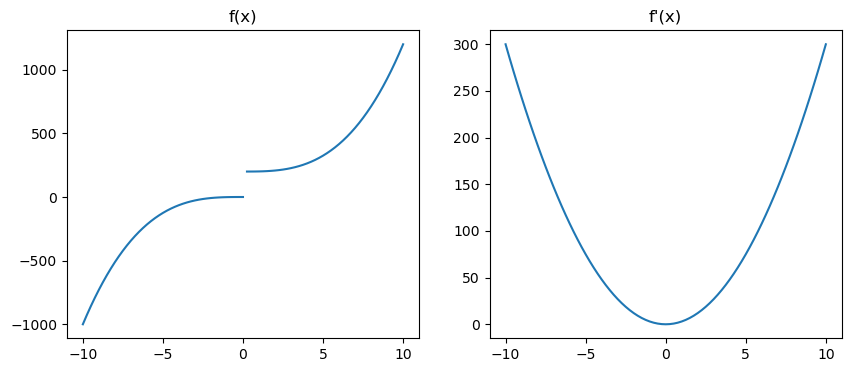

In [3]:
compute_f_and_df(my_jump_function)

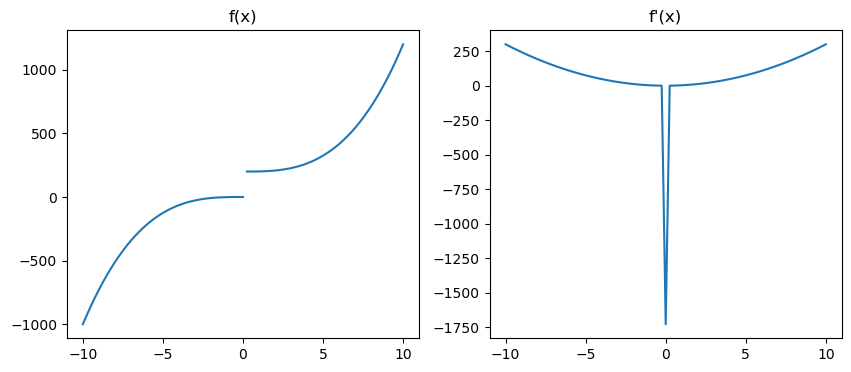

In [4]:
# Visualizing function where we define -1728 as derivative for x=0
compute_f_and_df(my_jump_function_2)

### 1.2 Inconsistent derivatives of a differentiable function.

Consider the (mathematical) function $g(x) = x^4$. Clearly, $g$ is differentiable everywhere.
- Implement $g$ as a DiffProg function in PyTorch so that PyTorch returns a derivative of $0$ at $\hat{x} = 0$.
- Implement $g$ again in DiffProg so that PyTorch now returns a derivative of $897$ at exactly the same point $\hat{x} = 0$.

The takeaway message of this exercise is that the data scientist must make sure the inputs to automatic differentiation are well-defined mathematically.

Hint: Use branches again. For the second function, use two branches $x = 0$ and $x \neq 0$.

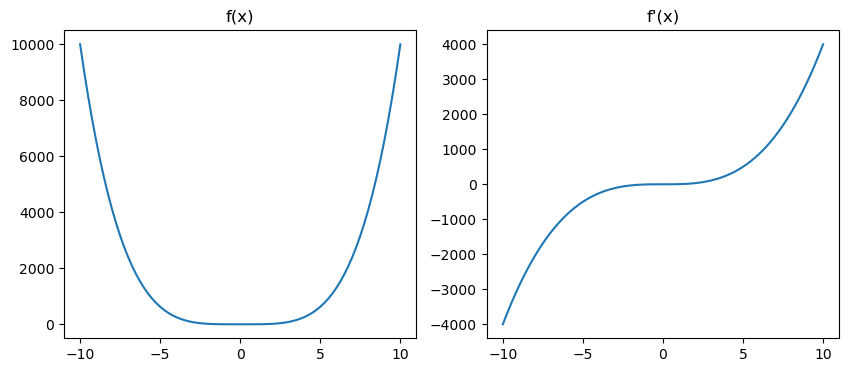

In [5]:
# Should return derivative of 0 at x=0
def g_1(x):
    return x**4

# Should return derivative of 897 at x=0
def g_2(x):
    if x==0:
        return 897*x
    else:
        return x**4

compute_f_and_df(g_1, jump=False)

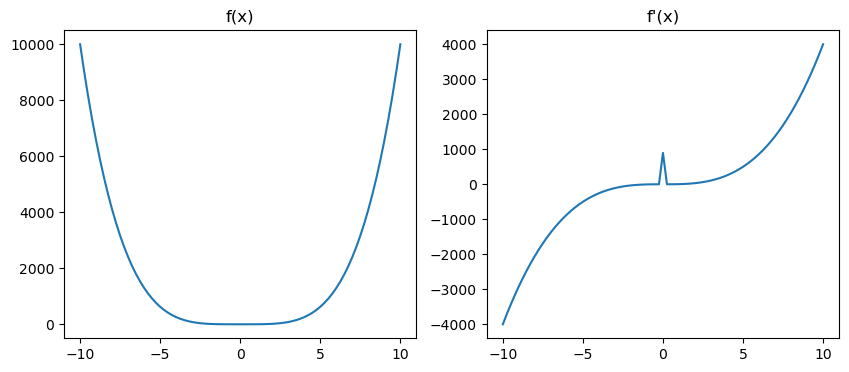

In [6]:
compute_f_and_df(g_2, jump=False)

### 1.3 Derivatives with loops: When is it valid?

In the lab, we defined a (mathematical) function $h(x, n) = \sum_{i=1}^{n} x^{n−1}$. We implemented this in DiffProg using a loop such that automatic differentiation gives us $∂ h(x, n)$ correctly. In this exercise, we will define $∂x$ a DiffProg function with a loop so that the underlying mathematical function is discontinuous.

- Write a DiffProg function in PyTorch which takes an input $x_0$ and iteratively updates $x_{t+1} \leftarrow x_t/2$ until a stopping criterion $|x_t| < 10^{−6}$ is satisfied.
- Plot this function in the range $[−2, 2]$. Are the derivatives of this function well-defined everywhere?
- Find a point $\hat{x}$ such that implementing the stopping criterion as $|x_t| < 10^{−6}$ or $|x_t| ≤ 10^{−6}$ changes the value of the derivative returned by PyTorch. Is the derivative mathematically well-defined at $\hat{x}$?
- Write out the (mathematical) function $ψ : \mathbb{R} → \mathbb{R}$ which is implemented by this DiffProg function.

The takeaway message of this part is that one must be careful when defining DiffProg functions with loops. The stopping criterion of the loop must not depend on the input which respect to which we compute a derivative.


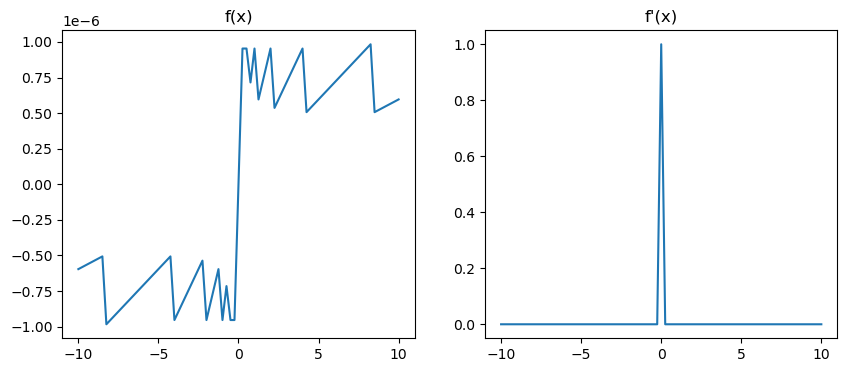

In [7]:
# Writing DiffProg function and plotting it for [-2,2]

def my_func_discontinuous(x0, condition='<'):
    if condition == '<':
        while torch.abs(x0) >= 1e-6:
            x0 = x0/2
    elif condition == '<=':
        while torch.abs(x0) > 1e-6:
            x0 = x0/2
    else:
        raise ValueError #"Must be < or <="
    return x0

compute_f_and_df(my_func_discontinuous, jump=False)

We see that in the range $[-2,2]$ the derivatives are not well defined as we see a lot of discontinuities at various points in the plot such as $x=±1$. There is also a jump discontinuity at x=0.

In [8]:
# Since we are changing the stopping condition, the derivative at the stopping condition is likely to vary
x = torch.tensor(1e-6, requires_grad=True)
y = my_func_discontinuous(x,condition='<')
grad = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(x, grad, "(using < in terminating condition)")

y = my_func_discontinuous(x,condition='<=')
grad = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(x, grad, "(using <= in terminating condition)")

tensor(1.0000e-06, requires_grad=True) tensor(0.5000) (using < in terminating condition)
tensor(1.0000e-06, requires_grad=True) tensor(1.) (using <= in terminating condition)


We see that our assumption is correct. We now plot the derivative at this point for both the conditions to see whether the derivative is well defined.

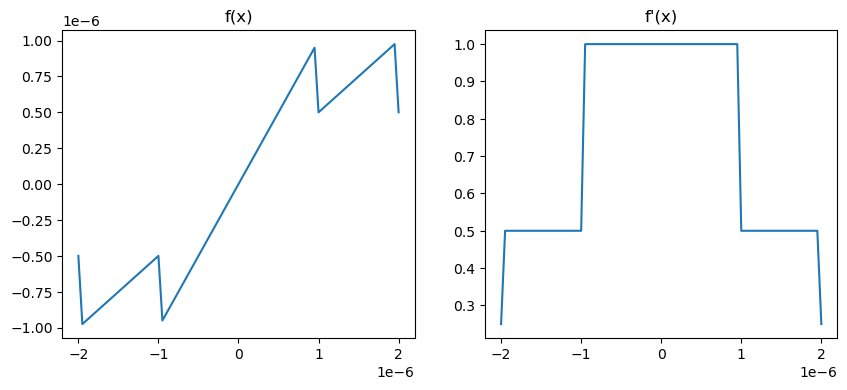

In [9]:
compute_f_and_df(my_func_discontinuous, jump=False, xs=torch.linspace(-2e-6,2e-6,81, requires_grad=True), condition='<')

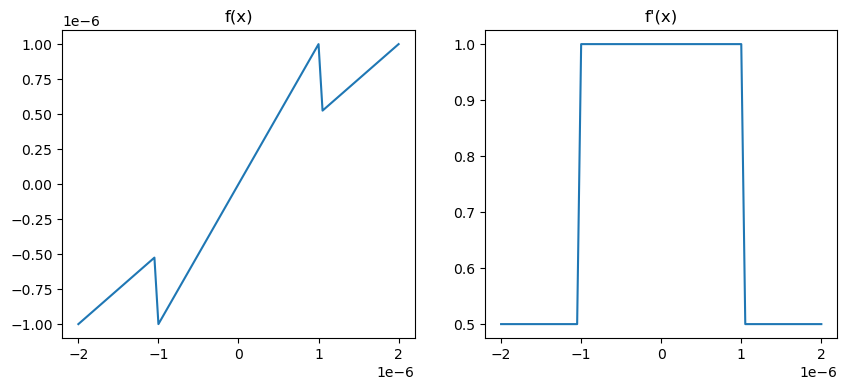

In [10]:
compute_f_and_df(my_func_discontinuous, jump=False, xs=torch.linspace(-2e-6,2e-6,81, requires_grad=True), condition='<=')

We see that the derivative is not well defined at |1e-6| as there is a jump between 0.5 and 1

The mathematical function implemented by this DiffProg function is as follows:

$$
f(x) = \begin{cases} 
f(x/2); \text{ if } x \ge 10^{-6}\\
0 \text{; otherwise}
\end{cases}
$$

### 1.4 When can we not use branches in differentiable programs?

Consider the mathematical function $\phi : \mathbb{R} → [0, 1]$ by
$$

\phi(x) = \begin{cases} 1 \text{ if } x \ge 0 \\
0 \text{ otherwise}

\end{cases}
$$
- Plot this function. Is it continuous? Is it differentiable almost everywhere?
- Implement this in PyTorch. Try to compute its derivatives. What do we get?
- Can we train a differentiable program containing this function as a component using stochastic gradient descent? Why or why not? Justify your answer in words.

**Note:** The classification accuracy of a binary classifier can be computed using the function φ. Why d o we use logistic regression to train a classifier and not use the classification accuracy directly?

*Solution:*

This function is continuous and differentiable almost everywhere, with the exception of $x = 0$ where we observe a jump discontinuity.

We plot it along with its derivative after implementing it as a DiffProg in PyTorch (in the interest of resuing code!)

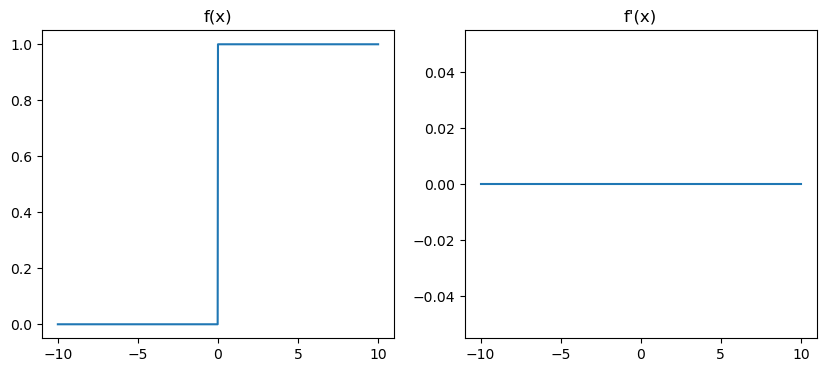

In [11]:
def my_func_0_1(x):
    if x >= 0:
        return torch.ones_like(x, requires_grad=True)
    else:
        return torch.zeros_like(x, requires_grad=True)

compute_f_and_df(my_func_0_1, jump=False, xs=torch.linspace(-10,10,1001,requires_grad=True))

We get a derivative of 0 over all ranges of values.

We cannot train a stochastic gradient descent model using this function as a component because this function has a gradient of 0. Due to this we will always have an update of value of 0 and stoachstic gradient descent will be unable to update the parameters.

## 2. Data Augmentation

Data augmentation can be applied at training time or testing time.

- Training time: in each iteration, we sample a minibatch, take one transformation per-image and use those instead to compute the minibatch stochastic gradient. The rest of the training loop continues as usual.
- Test time: we predict an output for an image x as follows. Take augmentations $x_1, x_2, · · · , x_T$ of $x$. For each augmented image $x_i$, obtain prediction $y_i$. The combined prediction $y$ for image $x$ is obtained by taking a majority vote from $y_1, · · · , y_T$. Note that the augmentations can only be used to compute the accuracy but not the loss.

In this exercise, we will try four combinations:
1. No data augmentation for training or testing
2. Use data augmentation for training but not for testing
3. Use data augmentation for testing but not for training
4. Use data augmentation for both training and testing

Here are the details:
- The setup is identical to the lab. Take the FashionMNIST dataset and randomly subsample 12% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.
- We will use a convolutional neural network defined in the lab.
- Use a batch size of 16 and a learning rate of 0.04.
- Train the model for 100 passes through the data or until you observe perfect interpolation of the training data (i.e., the training accuracy is 100%).
- We will use a random crop and a random rotation as our transformations.
- For testing time, use T = 8 augmentations for each image. 

The deliverables are:
1. Report the final test accuracy for each of the 4 settings considered above.
2. Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of training (i.e., the metric on the y-axis and number of effective passes on the x-axis). Plot all 4 lines on the same plot.

**Hint:** You may use the function “transform_selected_data” defined in this week’s demo to perform the data augmentations.

In [12]:
import numpy as np
import pandas as pd
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(1)

### 2.1 Loading the MNIST dataset and setting up the CNN

We load the MNIST dataset and set up some helper functions to preprocess the data and train the model

X_train.shape = torch.Size([7200, 28, 28])
n_train: 7200, n_test: 10000
Image size: torch.Size([28, 28])


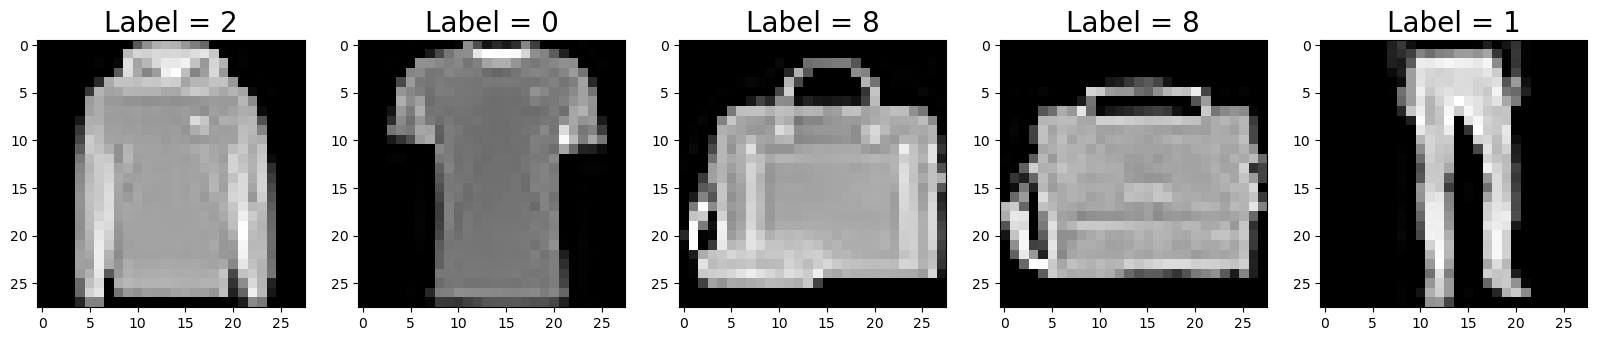

In [13]:
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# download dataset (~117M in size)
train_dataset = FashionMNIST('../../data', train=True, download=False)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('../../data', train=False, download=False)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=int(X_train.shape[0]*0.12))).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [14]:
# Use this for your homework

def transform_selected_data(X):
    # X is of shape (B, 784), where B is the batch_size
    X = X.view(-1, 28, 28)  # reshape to 28x28
    transform1 = transforms.RandomResizedCrop((28, 28), scale=(0.75, 1.0), ratio=(0.75, 1.33), interpolation=2)
    transform2 = transforms.RandomRotation((-10, 10))
    X_transformed = transform2(transform1(X))
    return X_transformed.view(-1, 784) # reshape into a vector


# call, e.g., as `transform_selected_data(X_train[:10])`

In [15]:
from torch.nn.functional import cross_entropy

def compute_objective(net, X, y):
    """ Compute the multinomial logistic loss. 
        net is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = net(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(net, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = net(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    # Return the fraction of predictions that are correct
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(net, verbose=False):
    train_loss = compute_objective(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_accuracy = compute_accuracy(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)


def minibatch_sgd_one_pass(net, X, y, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        # TODO: your code here: sample `batch_size` many indices from {0, ..., num_examples-1}
        idxs = np.random.choice(num_examples, size=(batch_size,)) 
        # compute the objective. 
        objective = compute_objective(net, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # TODO: your code here: compute the gradient using automatic differentiation
        # Hint: you can access the parameters of `net.parameters()`
        gradients = torch.autograd.grad(outputs=objective, inputs=net.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        # Hint: you can access the parameters of `net.parameters()`
        with torch.no_grad():
            for (w, g) in zip(net.parameters(), gradients):
                w -= learning_rate * g
    return net

We will use a ConvNet written as a PyTorch module.

In [16]:
class MyConvNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fully_connected_layer = torch.nn.Linear(7*7*32, 10)
        # Note: the size 7*7*32 comes from the output size of the
        # previous layer. We will see how to find this next week.
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

### 2.2 Training and Test without data augmentations

In [17]:
learning_rate = 0.04

logs = []

model = MyConvNet(num_classes=10)
print('Iteration 0', end=', ')
logs.append(compute_logs(model, verbose=True))

batch_size = 16

for j in range(100):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs.append(log)
    if log[1] == 1.0:
        break

Iteration 0, Train Loss = 2.278, Train Accuracy = 0.145, Test Loss = 2.282, Test Accuracy = 0.144
Iteration 1, Train Loss = 0.507, Train Accuracy = 0.817, Test Loss = 0.544, Test Accuracy = 0.804
Iteration 2, Train Loss = 0.417, Train Accuracy = 0.847, Test Loss = 0.486, Test Accuracy = 0.831
Iteration 3, Train Loss = 0.325, Train Accuracy = 0.883, Test Loss = 0.436, Test Accuracy = 0.854
Iteration 4, Train Loss = 0.316, Train Accuracy = 0.885, Test Loss = 0.463, Test Accuracy = 0.842
Iteration 5, Train Loss = 0.271, Train Accuracy = 0.901, Test Loss = 0.410, Test Accuracy = 0.864
Iteration 6, Train Loss = 0.246, Train Accuracy = 0.914, Test Loss = 0.446, Test Accuracy = 0.865
Iteration 7, Train Loss = 0.262, Train Accuracy = 0.903, Test Loss = 0.498, Test Accuracy = 0.846
Iteration 8, Train Loss = 0.194, Train Accuracy = 0.933, Test Loss = 0.446, Test Accuracy = 0.863
Iteration 9, Train Loss = 0.158, Train Accuracy = 0.946, Test Loss = 0.423, Test Accuracy = 0.878
Iteration 10, Train 

### 2.3 Training with Data Augmentations

In [18]:
learning_rate = 0.04

logs_2 = []

model = MyConvNet(num_classes=10)
print('Iteration 0', end=', ')
logs_2.append(compute_logs(model, verbose=True))

batch_size = 16

for j in range(100):
    X_train_augmented = transform_selected_data(X_train)
    model = minibatch_sgd_one_pass(model, X_train_augmented, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_2.append(log)
    if log[1] == 1.0:
        break

Iteration 0, Train Loss = 2.316, Train Accuracy = 0.076, Test Loss = 2.316, Test Accuracy = 0.084


/Users/hridaybaghar/opt/miniconda3/envs/data598/lib/python3.8/site-packages/torchvision/transforms/transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Iteration 1, Train Loss = 0.708, Train Accuracy = 0.743, Test Loss = 0.741, Test Accuracy = 0.735
Iteration 2, Train Loss = 1.030, Train Accuracy = 0.658, Test Loss = 1.073, Test Accuracy = 0.661
Iteration 3, Train Loss = 1.189, Train Accuracy = 0.614, Test Loss = 1.236, Test Accuracy = 0.599
Iteration 4, Train Loss = 0.676, Train Accuracy = 0.776, Test Loss = 0.764, Test Accuracy = 0.753
Iteration 5, Train Loss = 0.489, Train Accuracy = 0.833, Test Loss = 0.593, Test Accuracy = 0.809
Iteration 6, Train Loss = 1.021, Train Accuracy = 0.735, Test Loss = 1.117, Test Accuracy = 0.722
Iteration 7, Train Loss = 0.436, Train Accuracy = 0.836, Test Loss = 0.534, Test Accuracy = 0.816
Iteration 8, Train Loss = 0.477, Train Accuracy = 0.812, Test Loss = 0.576, Test Accuracy = 0.792
Iteration 9, Train Loss = 0.686, Train Accuracy = 0.762, Test Loss = 0.787, Test Accuracy = 0.747
Iteration 10, Train Loss = 0.364, Train Accuracy = 0.869, Test Loss = 0.488, Test Accuracy = 0.842
Iteration 11, Train

### 2.4 Test data with augmentations

In [19]:
@torch.no_grad()
def compute_accuracy_augment(net, X, y):
    """ Compute the classification accuracy of the augmented set
        X of shape (n, d) and y of shape (n,)
    """
    pooled_preds = torch.zeros(y.shape[0], 8)
    for i in range(8):
        X_augment = transform_selected_data(X)
        score = net(X_augment)
        predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
        pooled_preds[:,i] = predictions
    
    final_predictions = torch.mode(pooled_preds, 1).values
    # Return the fraction of predictions that are correct
    return (final_predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs_test_augment(net, verbose=False):
    train_loss = compute_objective(net, X_train, y_train)
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    test_accuracy = compute_accuracy_augment(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)


In [20]:
learning_rate = 0.04

logs_3 = []

model = MyConvNet(num_classes=10)
print('Iteration 0', end=', ')
logs_3.append(compute_logs_test_augment(model, verbose=True))

batch_size = 16

for j in range(100):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs_test_augment(model, verbose=True)
    logs_3.append(log)
    if log[1] == 1.0:
        break

Iteration 0, Train Loss = 2.310, Train Accuracy = 0.059, Test Loss = 2.312, Test Accuracy = 0.077
Iteration 1, Train Loss = 0.482, Train Accuracy = 0.831, Test Loss = 0.530, Test Accuracy = 0.786
Iteration 2, Train Loss = 0.389, Train Accuracy = 0.861, Test Loss = 0.474, Test Accuracy = 0.793
Iteration 3, Train Loss = 0.356, Train Accuracy = 0.873, Test Loss = 0.460, Test Accuracy = 0.806
Iteration 4, Train Loss = 0.312, Train Accuracy = 0.891, Test Loss = 0.444, Test Accuracy = 0.812
Iteration 5, Train Loss = 0.286, Train Accuracy = 0.897, Test Loss = 0.437, Test Accuracy = 0.806
Iteration 6, Train Loss = 0.278, Train Accuracy = 0.898, Test Loss = 0.470, Test Accuracy = 0.819
Iteration 7, Train Loss = 0.219, Train Accuracy = 0.925, Test Loss = 0.469, Test Accuracy = 0.808
Iteration 8, Train Loss = 0.178, Train Accuracy = 0.939, Test Loss = 0.416, Test Accuracy = 0.826
Iteration 9, Train Loss = 0.159, Train Accuracy = 0.944, Test Loss = 0.444, Test Accuracy = 0.841
Iteration 10, Train 

### 2.5 Train and test data with augmentations

In [21]:
learning_rate = 0.04

logs_4 = []

model = MyConvNet(num_classes=10)
print('Iteration 0', end=', ')
logs_4.append(compute_logs_test_augment(model, verbose=True))

batch_size = 16

for j in range(100):
    X_train_augmented = transform_selected_data(X_train)
    model = minibatch_sgd_one_pass(model, X_train_augmented, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs_test_augment(model, verbose=True)
    logs_4.append(log)
    if log[1] == 1.0:
        break

Iteration 0, Train Loss = 2.332, Train Accuracy = 0.090, Test Loss = 2.330, Test Accuracy = 0.103
Iteration 1, Train Loss = 0.860, Train Accuracy = 0.698, Test Loss = 0.889, Test Accuracy = 0.721
Iteration 2, Train Loss = 0.582, Train Accuracy = 0.792, Test Loss = 0.635, Test Accuracy = 0.733
Iteration 3, Train Loss = 0.736, Train Accuracy = 0.725, Test Loss = 0.814, Test Accuracy = 0.718
Iteration 4, Train Loss = 0.464, Train Accuracy = 0.842, Test Loss = 0.541, Test Accuracy = 0.806
Iteration 5, Train Loss = 0.618, Train Accuracy = 0.798, Test Loss = 0.711, Test Accuracy = 0.776
Iteration 6, Train Loss = 0.392, Train Accuracy = 0.860, Test Loss = 0.498, Test Accuracy = 0.834
Iteration 7, Train Loss = 0.572, Train Accuracy = 0.832, Test Loss = 0.686, Test Accuracy = 0.814
Iteration 8, Train Loss = 0.431, Train Accuracy = 0.842, Test Loss = 0.531, Test Accuracy = 0.819
Iteration 9, Train Loss = 0.428, Train Accuracy = 0.848, Test Loss = 0.576, Test Accuracy = 0.807
Iteration 10, Train 

## 3. Deliverables

In [22]:
print(f"Final test accuracy for - \n1. No augmentations:{round(logs[-1][3].item(),4)}\n2. Training augmentations:{round(logs_2[-1][3].item(),4)}\n\
3. Test augmentations:{round(logs_3[-1][2].item(),4)}\n4. Train and test augmentations:{round(logs_4[-1][2].item(),4)}")

Final test accuracy for - 
1. No augmentations:0.8767
2. Training augmentations:0.8613
3. Test augmentations:0.8301
4. Train and test augmentations:0.6932


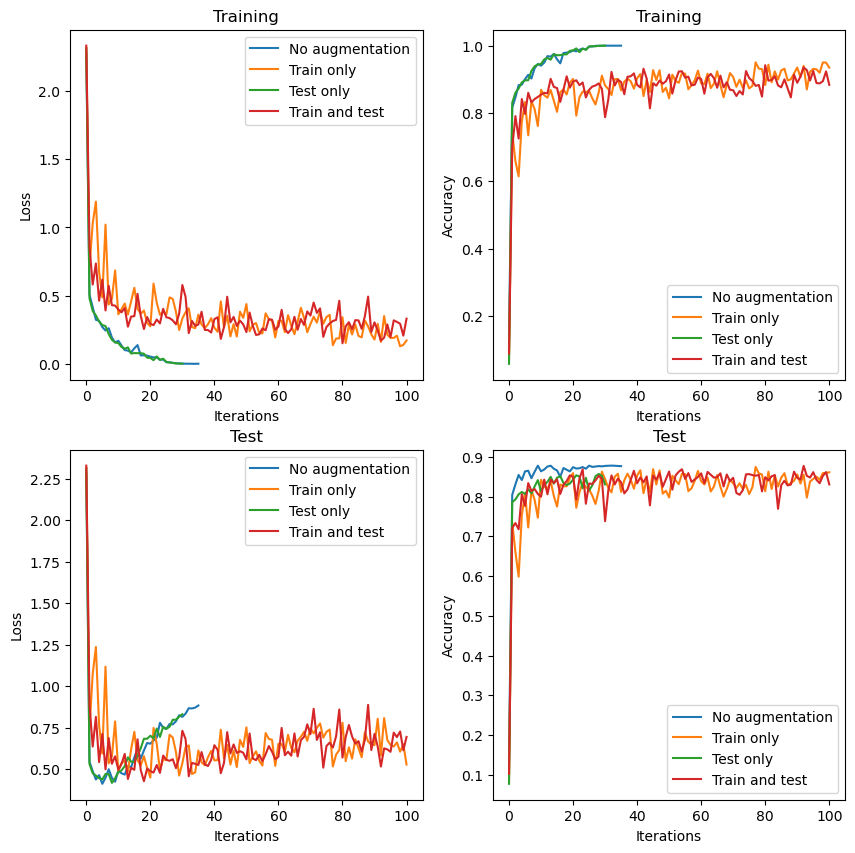

In [23]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10,10)
for a in ax.flatten(): a.set_xlabel("Iterations")
for a in ax: a[0].set_ylabel("Loss")
for a in ax: a[1].set_ylabel("Accuracy")
for a in ax[0,:]: a.set_title("Training")
for a in ax[1,:]: a.set_title("Test")

names = zip([logs, logs_2, logs_3, logs_4], ["No augmentation", "Train only", "Test only", "Train and test"])
for log, label in names:
    log = np.asarray(log)
    ax[0,0].plot(log[:,0], label = label)
    ax[0,0].legend()
    ax[0,1].plot(log[:,1], label = label)
    ax[0,1].legend()
    ax[1,0].plot(log[:,2], label = label)
    ax[1,0].legend()
    ax[1,1].plot(log[:,3], label = label)
    ax[1,1].legend()

## 3. (Bonus) Serial updates and gradient computations with minibatching

In this exercise, we will experiment with minibatching in a multilayer perceptron (MLP) with a single hidden layer.
When we make N passes over the data with n points, we have a total of Nn gradient computations. However, the number of updates we make to our model are:
- SGD: nN updates
- Minibatch SGD (batch size B): ⌊nN/B⌋

On the other hand, if we make T updates to our model, the number of gradient computations we need are:
- SGD: T gradient computations
- Minibatch SGD (batch size B): TB gradient computations.

Sometimes, the number of updates is the bottleneck (that is, computing the minibatch stochastic gradient is not much more expensive that computing a stochastic gradient with B = 1). This is true, for instance, on a GPU or similar hardware which allow massive parallelism. We will explore this setting in this exercise.

Here are the details:
- The setup is identical to the lab. Take the FashionMNIST dataset and randomly subsample 10% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.
- Define a MLP with one hidden layer of width h = 64. This model stays fixed throughout the homework.
- For each batch size B in [1, 2, 4, 8, 16], find the divergent learning rate ηB∗ . Use a fixed learning rate of ηB∗ /2 for this batch size.
- Train the model for 50n/B total updates,where n is the number of training examples. This corresponds to 50 passes over the data with a batch size of B.

The deliverables for this exercise are:
1. Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of training (i.e., the metric on the y-axis and number of updates on the x-axis). Plot all 5 lines, one for each value of B on the same plot.
2. When the training accuracy is 100%, the model is said to interpolate the training data. As we vary the batch size of the network, after how many updates do we observe perfect interpolation of the data? That is, make a plot with B on the x-axis and number of updates over the data required for interpolation on the y axis.

### 3.1 Model and dataset setup

Loading functions that will be required for model training and setting up the dataset.

In [24]:
train_dataset = FashionMNIST('../../data', train=True, download=False)
X_train = train_dataset.data # torch tensor of type uint8 of shape (n, 28, 28)
y_train = train_dataset.targets.long() # torch tensor of type Long of shape (n,)
test_dataset = FashionMNIST('../../data', train=False, download=False)
X_test = test_dataset.data
y_test = test_dataset.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
idxs_test = torch.from_numpy(
    np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]))
X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [25]:
print("Original Shape:", X_train.shape)
X_train = X_train.float()  # convert to float32. Shape: (n, 28, 28)
X_train = X_train.view(-1, 784)  # Shape: (n, 784)
print("Flatten Shape:", X_train.shape)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)

Original Shape: torch.Size([6000, 28, 28])
Flatten Shape: torch.Size([6000, 784])


In [26]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1
# Normalize: add a small number to avoid divide by zero
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float()  # Shape: (n', 28, 28)
X_test = X_test.view(-1, 784)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)
print("Number of Classes: ", n_class)


Number of Classes:  10


In [27]:
class MyMLP(torch.nn.Module):
    def __init__(self, input_size=28*28, hidden_size=64, output_size=10):
        super().__init__()
        self.first = torch.nn.Linear(input_size, hidden_size, bias = True)
        self.relu = torch.nn.ReLU()
        self.hidden = torch.nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x):
        out = self.first(x)
        out = self.relu(out)
        out = self.hidden(out)
        return out

### 3.2 Batchsize B=1

In [55]:
learning_rate = 1e-2 #This is the divergent learning rate because loss drops at this rate but diverges at 2x.
# We will use half of this learning rate to train the model

m = MyMLP()

_ = compute_logs(m, verbose=True)

m = minibatch_sgd_one_pass(m, X_train, y_train, learning_rate, batch_size=1, verbose=True)

_ = compute_logs(m, verbose=True)

Train Loss = 2.366, Train Accuracy = 0.067, Test Loss = 2.368, Test Accuracy = 0.069
0.974416346604489
1.0753523347023057
0.966634098340903
0.9007680527608988
0.8468360788500898
0.7355880813741213
0.6661370433117859
0.6864893779462412
0.6906161236764683
0.5806293729040899
0.7822189706508668
0.6675936899769224
0.6844457114762257
0.6750278747930445
0.5936547479875034
0.6256397777819377
0.6367422980041701
0.6756877022345822
0.6834341218803449
0.6180616851211336
0.5474070114075739
0.623664292529002
0.6261020576135105
0.5705171443151482
0.5475538500576326
0.6181187050683138
0.6104324484049267
0.6391293790597767
0.6979250103322853
0.5352974924452802
0.570753971045936
0.5563812545113257
0.6364645780924515
0.5513003021929184
0.6770695803465413
0.6110953326915967
0.546542476375991
0.5076721493322616
0.44419508129634405
0.42566001934437425
0.49809021007962084
0.6461815333688292
0.502682453685731
0.5579887509589245
0.4733299941718147
0.47759464637935056
0.5421462620287446
0.6096985788029087
0.533

In [39]:
learning_rate = 5e-3

logs_1 = []

model = MyMLP()
print('Iteration 0', end=', ')
logs_1.append(compute_logs(model, verbose=True))

batch_size = 1

for j in range(50):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_1.append(log)

Iteration 0, Train Loss = 2.270, Train Accuracy = 0.082, Test Loss = 2.273, Test Accuracy = 0.081
Iteration 1, Train Loss = 0.479, Train Accuracy = 0.827, Test Loss = 0.599, Test Accuracy = 0.781
Iteration 2, Train Loss = 0.359, Train Accuracy = 0.868, Test Loss = 0.529, Test Accuracy = 0.815
Iteration 3, Train Loss = 0.309, Train Accuracy = 0.886, Test Loss = 0.551, Test Accuracy = 0.819
Iteration 4, Train Loss = 0.292, Train Accuracy = 0.886, Test Loss = 0.573, Test Accuracy = 0.807
Iteration 5, Train Loss = 0.241, Train Accuracy = 0.913, Test Loss = 0.562, Test Accuracy = 0.822
Iteration 6, Train Loss = 0.263, Train Accuracy = 0.899, Test Loss = 0.621, Test Accuracy = 0.816
Iteration 7, Train Loss = 0.219, Train Accuracy = 0.922, Test Loss = 0.620, Test Accuracy = 0.829
Iteration 8, Train Loss = 0.194, Train Accuracy = 0.927, Test Loss = 0.639, Test Accuracy = 0.824
Iteration 9, Train Loss = 0.166, Train Accuracy = 0.941, Test Loss = 0.651, Test Accuracy = 0.830
Iteration 10, Train 

### 3.3 Batchsize B=2

In [56]:
learning_rate = 2e-2 #This is the divergent learning rate because loss drops at this rate but diverges at 2x.
# We will use half of this learning rate to train the model

m = MyMLP()

_ = compute_logs(m, verbose=True)

m = minibatch_sgd_one_pass(m, X_train, y_train, learning_rate, batch_size=2, verbose=True)

_ = compute_logs(m, verbose=True)

Train Loss = 2.257, Train Accuracy = 0.127, Test Loss = 2.261, Test Accuracy = 0.127
0.7729382614183777
0.9336653405753497
0.859488250923458
0.7354358417599184
0.7099061835852792
0.6569066079515975
0.6513049850681548
0.6907795265716529
0.5520436258591795
0.5217105597385764
0.5024503756526784
0.6276014445534197
0.5626873149033752
0.6380108549894864
0.6100778013400624
0.5843644495156359
0.5472059206239577
0.5540708301373223
0.6066050231933374
0.558283160042
0.43448279956743696
0.5440893430814907
0.612013723013981
0.7640268648521376
0.65641057478905
0.581643724404412
0.5866416769159388
0.4870747797315959
0.5045821749725781
0.4861504705487816
Train Loss = 0.430, Train Accuracy = 0.850, Test Loss = 0.617, Test Accuracy = 0.803


In [41]:
learning_rate = 1e-2

logs_2 = []

model = MyMLP()
print('Iteration 0', end=', ')
logs_2.append(compute_logs(model, verbose=True))

batch_size = 2

for j in range(50):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_2.append(log)

Iteration 0, Train Loss = 2.283, Train Accuracy = 0.125, Test Loss = 2.286, Test Accuracy = 0.123
Iteration 1, Train Loss = 0.423, Train Accuracy = 0.846, Test Loss = 0.543, Test Accuracy = 0.814
Iteration 2, Train Loss = 0.366, Train Accuracy = 0.865, Test Loss = 0.548, Test Accuracy = 0.815
Iteration 3, Train Loss = 0.303, Train Accuracy = 0.890, Test Loss = 0.547, Test Accuracy = 0.830
Iteration 4, Train Loss = 0.287, Train Accuracy = 0.897, Test Loss = 0.598, Test Accuracy = 0.821
Iteration 5, Train Loss = 0.246, Train Accuracy = 0.909, Test Loss = 0.598, Test Accuracy = 0.826
Iteration 6, Train Loss = 0.223, Train Accuracy = 0.919, Test Loss = 0.621, Test Accuracy = 0.830
Iteration 7, Train Loss = 0.201, Train Accuracy = 0.929, Test Loss = 0.659, Test Accuracy = 0.829
Iteration 8, Train Loss = 0.175, Train Accuracy = 0.940, Test Loss = 0.665, Test Accuracy = 0.830
Iteration 9, Train Loss = 0.169, Train Accuracy = 0.937, Test Loss = 0.718, Test Accuracy = 0.817
Iteration 10, Train 

### 3.4 Batchsize B=4

In [53]:
learning_rate = 5e-2 #This is the divergent learning rate because loss drops at this rate but diverges at 2x.
# We will use half of this learning rate to train the model

m = MyMLP()

_ = compute_logs(m, verbose=True)

m = minibatch_sgd_one_pass(m, X_train, y_train, learning_rate, batch_size=4, verbose=True)

_ = compute_logs(m, verbose=True)

Train Loss = 2.305, Train Accuracy = 0.105, Test Loss = 2.306, Test Accuracy = 0.107
0.6936996105000219
0.7715331804393337
0.8272157743889086
0.7089509957374267
0.7426418443036163
0.6847997072541111
0.7027470333730825
0.721166732759063
0.6170118247338459
0.7330198857930935
0.8282874122203405
0.7170073347251317
0.793384530771122
0.7377689027381511
0.6174942205141698
Train Loss = 0.648, Train Accuracy = 0.787, Test Loss = 0.849, Test Accuracy = 0.752


In [54]:
learning_rate = 2.5e-2

logs_4 = []

model = MyMLP()
print('Iteration 0', end=', ')
logs_4.append(compute_logs(model, verbose=True))

batch_size = 4

for j in range(50):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_4.append(log)

Iteration 0, Train Loss = 2.307, Train Accuracy = 0.128, Test Loss = 2.310, Test Accuracy = 0.131
Iteration 1, Train Loss = 0.426, Train Accuracy = 0.845, Test Loss = 0.566, Test Accuracy = 0.811
Iteration 2, Train Loss = 0.402, Train Accuracy = 0.857, Test Loss = 0.608, Test Accuracy = 0.809
Iteration 3, Train Loss = 0.330, Train Accuracy = 0.878, Test Loss = 0.610, Test Accuracy = 0.806
Iteration 4, Train Loss = 0.288, Train Accuracy = 0.892, Test Loss = 0.603, Test Accuracy = 0.819
Iteration 5, Train Loss = 0.262, Train Accuracy = 0.905, Test Loss = 0.640, Test Accuracy = 0.823
Iteration 6, Train Loss = 0.223, Train Accuracy = 0.912, Test Loss = 0.660, Test Accuracy = 0.818
Iteration 7, Train Loss = 0.224, Train Accuracy = 0.917, Test Loss = 0.682, Test Accuracy = 0.822
Iteration 8, Train Loss = 0.189, Train Accuracy = 0.935, Test Loss = 0.694, Test Accuracy = 0.829
Iteration 9, Train Loss = 0.198, Train Accuracy = 0.928, Test Loss = 0.764, Test Accuracy = 0.825
Iteration 10, Train 

### 3.5 Batchsize B=8

In [62]:
learning_rate = 1e-1 #This is the divergent learning rate because loss drops at this rate but diverges at 2x.
# We will use half of this learning rate to train the model

m = MyMLP()

_ = compute_logs(m, verbose=True)

m = minibatch_sgd_one_pass(m, X_train, y_train, learning_rate, batch_size=8, verbose=True)

_ = compute_logs(m, verbose=True)

Train Loss = 2.363, Train Accuracy = 0.100, Test Loss = 2.366, Test Accuracy = 0.096
0.5865276895816071
0.6583819794771345
0.6676653970868123
0.7086728470385192
0.7751042321769885
0.7104311893192502
0.740912214343978
Train Loss = 0.564, Train Accuracy = 0.821, Test Loss = 0.782, Test Accuracy = 0.784


In [63]:
learning_rate = 5e-2

logs_8 = []

model = MyMLP()
print('Iteration 0', end=', ')
logs_8.append(compute_logs(model, verbose=True))

batch_size = 8

for j in range(50):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_8.append(log)

Iteration 0, Train Loss = 2.318, Train Accuracy = 0.147, Test Loss = 2.323, Test Accuracy = 0.142
Iteration 1, Train Loss = 0.495, Train Accuracy = 0.810, Test Loss = 0.619, Test Accuracy = 0.783
Iteration 2, Train Loss = 0.421, Train Accuracy = 0.847, Test Loss = 0.638, Test Accuracy = 0.801
Iteration 3, Train Loss = 0.387, Train Accuracy = 0.854, Test Loss = 0.658, Test Accuracy = 0.794
Iteration 4, Train Loss = 0.373, Train Accuracy = 0.871, Test Loss = 0.694, Test Accuracy = 0.796
Iteration 5, Train Loss = 0.296, Train Accuracy = 0.898, Test Loss = 0.686, Test Accuracy = 0.814
Iteration 6, Train Loss = 0.240, Train Accuracy = 0.911, Test Loss = 0.632, Test Accuracy = 0.827
Iteration 7, Train Loss = 0.220, Train Accuracy = 0.920, Test Loss = 0.712, Test Accuracy = 0.819
Iteration 8, Train Loss = 0.169, Train Accuracy = 0.939, Test Loss = 0.650, Test Accuracy = 0.837
Iteration 9, Train Loss = 0.164, Train Accuracy = 0.942, Test Loss = 0.731, Test Accuracy = 0.828
Iteration 10, Train 

### 3.6 Batchsize B=16

In [70]:
learning_rate = 1.5e-1 #This is the divergent learning rate because loss drops at this rate but diverges at 2x.
# We will use half of this learning rate to train the model

m = MyMLP()

_ = compute_logs(m, verbose=True)

m = minibatch_sgd_one_pass(m, X_train, y_train, learning_rate, batch_size=16, verbose=True)

_ = compute_logs(m, verbose=True)

Train Loss = 2.336, Train Accuracy = 0.103, Test Loss = 2.344, Test Accuracy = 0.104
0.5187517750714284
0.6217241615490632
0.6003062295930539
Train Loss = 0.563, Train Accuracy = 0.790, Test Loss = 0.786, Test Accuracy = 0.755


In [71]:
learning_rate = 1.5e-1/2

logs_16 = []

model = MyMLP()
print('Iteration 0', end=', ')
logs_16.append(compute_logs(model, verbose=True))

batch_size = 16

for j in range(50):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    log = compute_logs(model, verbose=True)
    logs_16.append(log)

Iteration 0, Train Loss = 2.286, Train Accuracy = 0.151, Test Loss = 2.287, Test Accuracy = 0.146
Iteration 1, Train Loss = 0.436, Train Accuracy = 0.833, Test Loss = 0.548, Test Accuracy = 0.796
Iteration 2, Train Loss = 0.385, Train Accuracy = 0.858, Test Loss = 0.567, Test Accuracy = 0.801
Iteration 3, Train Loss = 0.336, Train Accuracy = 0.878, Test Loss = 0.583, Test Accuracy = 0.808
Iteration 4, Train Loss = 0.250, Train Accuracy = 0.910, Test Loss = 0.537, Test Accuracy = 0.828
Iteration 5, Train Loss = 0.273, Train Accuracy = 0.896, Test Loss = 0.597, Test Accuracy = 0.818
Iteration 6, Train Loss = 0.209, Train Accuracy = 0.926, Test Loss = 0.563, Test Accuracy = 0.833
Iteration 7, Train Loss = 0.205, Train Accuracy = 0.923, Test Loss = 0.612, Test Accuracy = 0.828
Iteration 8, Train Loss = 0.168, Train Accuracy = 0.944, Test Loss = 0.602, Test Accuracy = 0.836
Iteration 9, Train Loss = 0.188, Train Accuracy = 0.931, Test Loss = 0.668, Test Accuracy = 0.829
Iteration 10, Train 

### 3.7 Deliverables

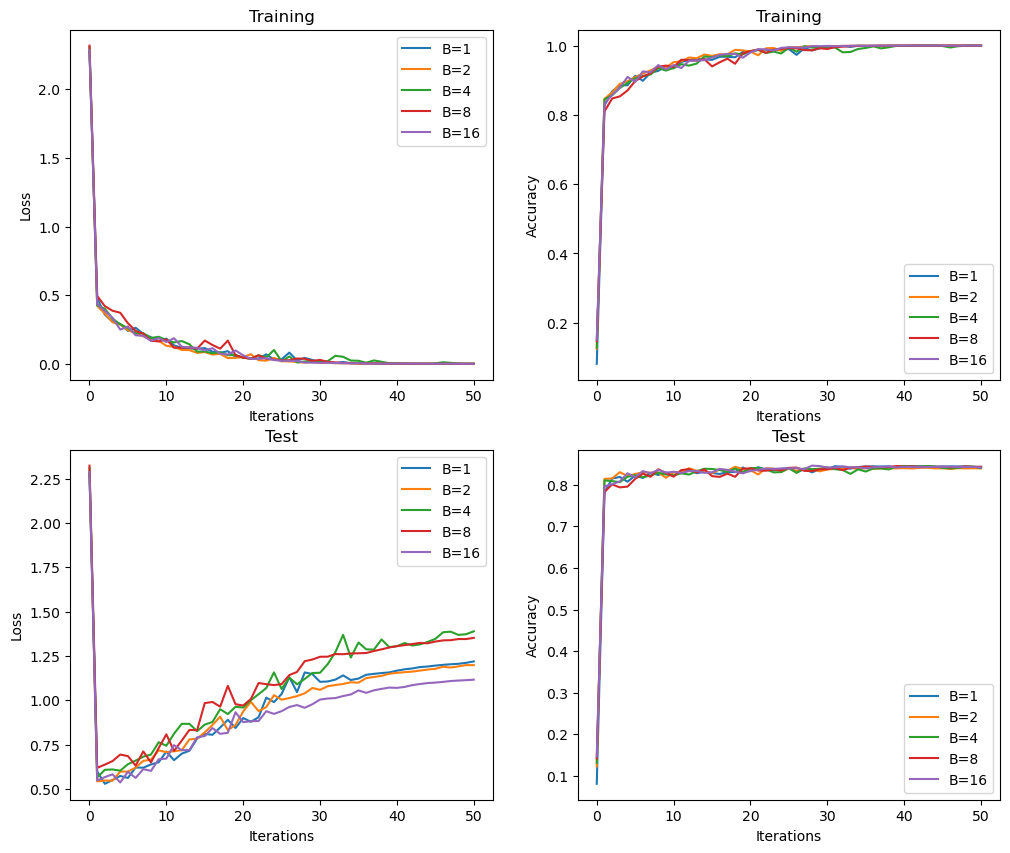

In [73]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,10)
for a in ax.flatten(): a.set_xlabel("Iterations")
for a in ax: a[0].set_ylabel("Loss")
for a in ax: a[1].set_ylabel("Accuracy")
for a in ax[0,:]: a.set_title("Training")
for a in ax[1,:]: a.set_title("Test")

names = zip([logs_1, logs_2, logs_4, logs_8, logs_16], ["B=1", "B=2", "B=4", "B=8", "B=16"])
for log, label in names:
    log = np.asarray(log)
    ax[0,0].plot(log[:,0], label = label)
    ax[0,0].legend()
    ax[0,1].plot(log[:,1], label = label)
    ax[0,1].legend()
    ax[1,0].plot(log[:,2], label = label)
    ax[1,0].legend()
    ax[1,1].plot(log[:,3], label = label)
    ax[1,1].legend()

In [89]:
def find_interpolation_index(log):
    log = np.asarray(log)
    idx = np.where(log[:,1]==1.0)[0]
    return idx.min()

idx = {}
names = zip([logs_1, logs_2, logs_4, logs_8, logs_16], ["B=1", "B=2", "B=4", "B=8", "B=16"])
for log, label in names:
    idx[label] = find_interpolation_index(log)
print(idx)

{'B=1': 39, 'B=2': 41, 'B=4': 42, 'B=8': 40, 'B=16': 34}


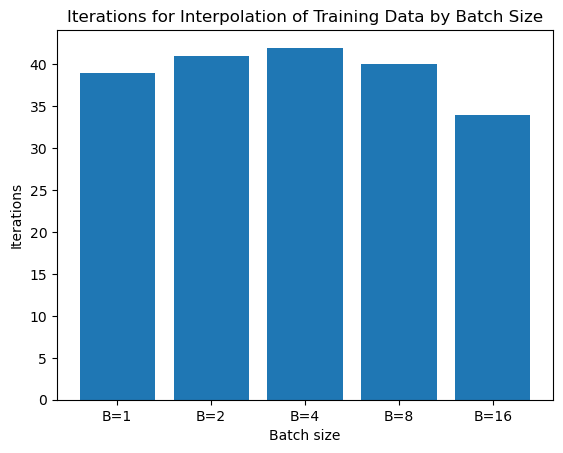

In [104]:
plt.bar(idx.keys(), idx.values());
plt.xlabel("Batch size");
plt.ylabel("Iterations")
plt.title("Iterations for Interpolation of Training Data by Batch Size");